In [2]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
from smdtLibs import utils, drawUtils, DARCalculator
from astropy.modeling import models, fitting

import glob

from Test_Input1 import Test_Inputs

sys.path.append("/home/kalahuipuaa/skwok/hq/data/libs/")
import LevMarqFitter

In [3]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

<IPython.core.display.Javascript object>

In [4]:
prefix = "../DeimosExamples/Examples2/"

<IPython.core.display.Javascript object>

In [5]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)


<IPython.core.display.Javascript object>

### Compare PNT center with calculated center

- Read PNT center from MDF file
- Read center from out file
- Put results in array and create a data frame

In [6]:
out = []
for f in glob.glob(prefix + "*.fits"):
    bname = os.path.basename(f).split(".")
    mdf = MaskDesignInputFitsFile(f)
    pntRa, pntDec, pntPa = mdf.getPNTCenter()
    tFile = f.replace("fits", "out")
    tlx = TargetList(tFile, config=config)
    out.append((pntPa, pntRa, pntDec, tlx.centerRADeg, tlx.centerDEC))

df = pd.DataFrame(out, columns=("Angle", "PntRa", "PntDec", "CenRa", "CenDec"))

<IPython.core.display.Javascript object>

In [7]:
cenx, ceny = df.CenRa.mean(), df.CenDec.mean()

<IPython.core.display.Javascript object>

In [8]:
def model (xys, x0, y0, r0):
    xs, ys = xys
    s = xs**2 - 2.0 * xs * x0 + x0**2 + ys**2 - 2.0 * ys *y0 + y0**2 - r0 ** 2
    return np.sqrt(np.dot (s, s))
    
xs = np.array(list(zip(df.PntRa, df.PntDec))).T
ys = np.zeros_like(df.PntRa)
initParms = (cenx, ceny, 300.0/3600)

lmf = LevMarqFitter.LevMarqFitter(tol=1E-8, debug=False)
results = lmf.fit(xs, ys, initParms, model)


<IPython.core.display.Javascript object>

In [9]:
results[2] * 3600

270.04100818321706

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


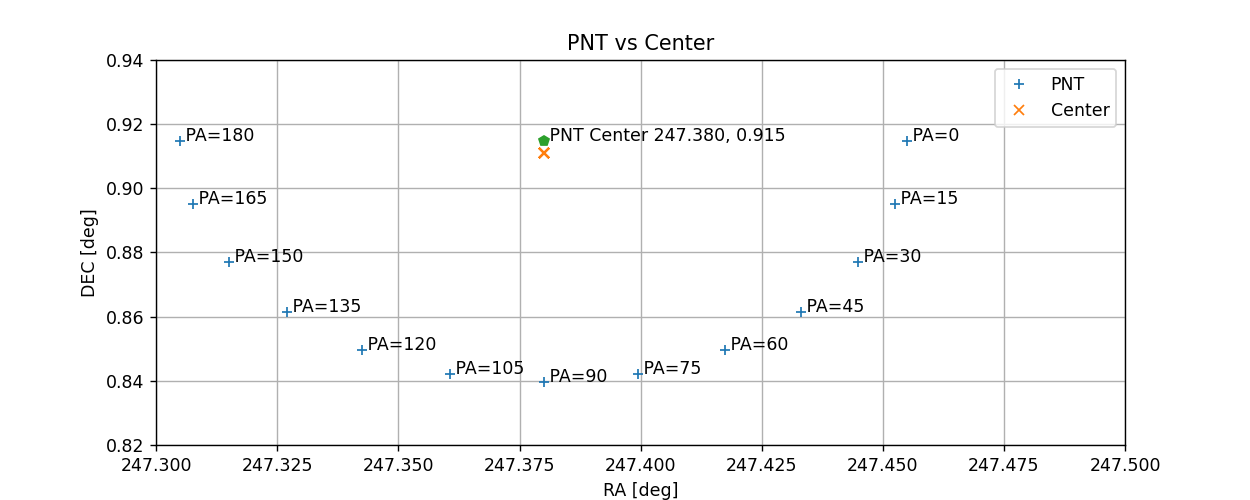

<IPython.core.display.Javascript object>

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(df.PntRa, df.PntDec, "+", label="PNT")
plt.plot(df.CenRa, df.CenDec, "x", label="Center")
for a, x, y in zip(df.Angle, df.PntRa, df.PntDec):
    plt.text(x, y, f" PA={a:.0f}")

plt.plot([results[0]], [results[1]], "p")
plt.text(results[0], results[1], f" PNT Center {results[0]:.3f}, {results[1]:.3f}")

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.ylim(0.82, 0.94)
plt.xlim(247.3, 247.5)
plt.legend()
plt.title("PNT vs Center")
plt.grid()

In [11]:
(ceny - results[1]) * 3600

-13.067049606494185

<IPython.core.display.Javascript object>

In [12]:
# Given a center (cx, cy)
# Calculates the PNT center

atRefr = DARCalculator.DARCalculator(
    config.properties["tellatitude"],
    config.properties["referencewavelen"] * 1000,
    615,
    0,
)

out = []
for f in glob.glob(prefix + "/*.fits"):
    mdf = MaskDesignInputFitsFile(f)
    pntRaDeg, pntDecDeg, pntPaDeg = mdf.getPNTCenter()

    tlist = TargetList(f.replace(".fits", ".out"), config=config)
    ra1, dec1 = tlist.toPNTCenter(pntPaDeg, mdf.maskdesign.LST_PNT[0])
    ra2, dec2 = np.degrees((tlist.telRaRad, tlist.telDecRad))
    # ra2, dec2 = mdf.getRotationCenter(config)
    out.append((f, pntRaDeg, pntDecDeg, ra1, dec1, ra2, dec2))

<IPython.core.display.Javascript object>

In [13]:
outT = [np.array(x) for x in zip(*out)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


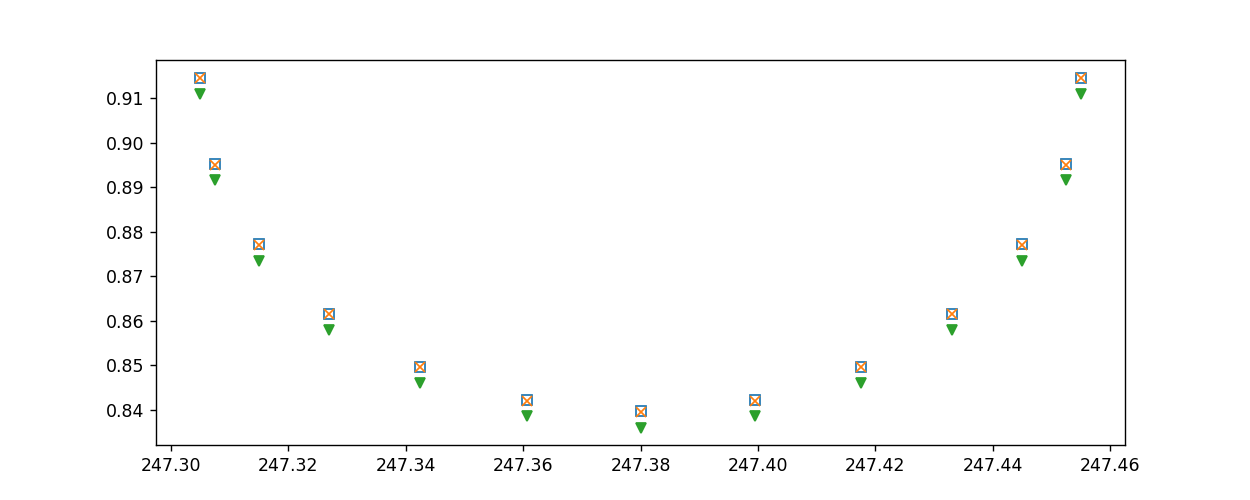

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(outT[1], outT[2], "s", mfc="None")
plt.plot(outT[3], outT[4], "x")
plt.plot(outT[5], outT[6], "v")

# dists = np.hypot(outT[1] - outT[3], outT[2] - outT[4]) * 3600
# plt.plot(outT[1], (outT[2] - outT[4]) * 3600, "x")

In [19]:
for n, a, b, c, d, e, f in out:
    print(c - e, d - f)

-6.835892634171614e-06 0.0034808951929093945
-5.560997749398666e-06 0.0034811063952338017
1.9665449713102134e-07 0.003481626230843138
-4.05130319336422e-06 0.003481300614907701
2.645426292247066e-06 0.0034816757461899606
-2.087198197386897e-06 0.0034814898825018536
-6.511438101597378e-06 0.0034809578244326955
5.094198087363111e-06 0.003481626230843027
1.0851850305471089e-05 0.0034811063952336907
7.378050781881029e-06 0.0034814898825018536
9.342155749436643e-06 0.003481300614907701
1.2126745218665747e-05 0.0034808951929093945
1.18022906576698e-05 0.0034809578244326955


<IPython.core.display.Javascript object>